In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import lightkurve as lk
import ellc
# import pandas as pd
# from scipy.interpolate import griddata

In [4]:
plt.style.use('science')


In [5]:
lit_period = 51.4213

In [6]:
ref_rv = 2400000
btjd = 2457000

rv_song = np.loadtxt('data/RV/SONG.txt')
rv_bischoff = np.loadtxt('data/RV/bischoff_rv_fixed_time.txt')
time, flux, flux_err = np.loadtxt('data/photometry/tess_corrected.txt', usecols=(0,1,2)).T

# Correct all to the same reference time
# time += btjd
rv_song[:,0] += ref_rv - btjd
rv_bischoff[:,0] += btjd - btjd

# Estimate t0s
m = time < 1700
lit_t0 = time[m][np.argmin(flux[m])]

m = (time > lit_t0 + 1.) & (time < 1740)
lit_t1 = time[m][np.argmin(flux[m])]

No handles with labels found to put in legend.


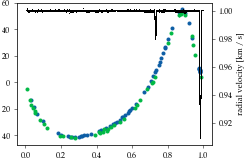

In [7]:
# x_song = np.ascontiguousarray(x_song, dtype=np.float64)
# y_song = np.ascontiguousarray(y_song, dtype=np.float64)

plt.errorbar(rv_song[:,0] % lit_period / lit_period, rv_song[:,1], yerr=rv_song[:,2],fmt='.')
plt.errorbar(rv_bischoff[:,0] % lit_period / lit_period, rv_bischoff[:,1], yerr=rv_bischoff[:,2], fmt='.')

ax2 = plt.twinx()
ax2.plot(time % lit_period / lit_period, flux, ',k')
ax2.set(ylabel='Flux')

plt.legend(fontsize=10)
plt.ylabel("radial velocity [km / s]")
_ = plt.xlabel("time since primary eclipse [days]")

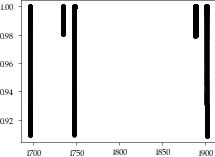

In [8]:
edge = 0.5
m = (
    (time < (lit_t0 + edge)) & (time > (lit_t0 - edge)) |
    (time < (lit_t1 + edge)) & (time > (lit_t1 - edge))
)
for i in range(1, 10):
    m = m | (
        (time < (lit_t0 + lit_period * i + edge)) & (time > (lit_t0 + lit_period * i - edge)) |
        (time < (lit_t1 + lit_period * i + edge)) & (time > (lit_t1 + lit_period * i - edge))
    )
plt.plot(time[m], flux[m], '.k')
time, flux, flux_err = time[m][::], flux[m][::], flux_err[m][::]


In [9]:
def q_to_u(q1, q2):
    return 2*np.sqrt(q1)*q2, np.sqrt(q1)*(1 - 2*q2)

def lc_model(θ, x):
    period, rsum, rratio, incl, sbratio, t0, f_c, f_s, sma, gammava, gammavb, q11, q12, q21, q22, mean, vsini, loglc, logrv_a, logrv_b = θ

    r1, r2 = rsum/(1.+rratio), rsum*rratio/(1.+rratio)
    lc = ellc.lc(x,t_zero=t0,
                radius_1=r1, radius_2=r2,
                incl=incl,
                 vsini_1 = vsini,
                sbratio=sbratio, shape_1='sphere', shape_2='sphere',
                period=period, f_c=f_c, f_s=f_s,
                 # Limb darkening
                ld_1='quad', ld_2='quad', ldc_1=q_to_u(q11,q12), ldc_2=q_to_u(q21,q22),
                a=sma,)
    return lc + mean

def rv_model(θ, x):

    period, rsum, rratio, incl, sbratio, t0, f_c, f_s, sma, gammava, gammavb, q11, q12, q21, q22, mean, vsini, loglc, logrv_a, logrv_b = θ

    r1, r2 = rsum/(1.+rratio), rsum*rratio/(1.+rratio)  
    rv = ellc.rv(x,t_zero=t0,
                radius_1=r1, radius_2=r2,
                incl=incl,
                 vsini_1 = vsini,
                sbratio=sbratio, shape_1='sphere', shape_2='sphere',
                period=period, f_c=f_c, f_s=f_s,
                 # Limb darkening
                ld_1='quad', ld_2='quad', ldc_1=q_to_u(q11,q12), ldc_2=q_to_u(q21,q22),
                a=sma,)
    return rv[0]

def lnprior(θ):
    period, rsum, rratio, incl, sbratio, t0, f_c, f_s, sma, gammava, gammavb, q11, q12, q21, q22, mean, vsini, loglc, logrv_a, logrv_b = θ

    radius_1, radius_2 = rsum/(1.+rratio), rsum*rratio/(1.+rratio)
    prior = 0
    for param, bound in zip(θ, θ_bounds):
        if (bound[0] < param < bound[1]):
            prior += 0
        else:
            return -np.inf
    if (0 < radius_1 < 1) & (0 < radius_2 < 1):
        return prior
    else:
        return -np.inf

def lnlike(θ, time, flux, flux_err, rv_a, rv_b):
    period, rsum, rratio, incl, sbratio, t0, f_c, f_s, sma, gammava, gammavb, q11, q12, q21, q22, mean, vsini, loglc, logrv_a, logrv_b = θ

    if not np.isfinite(lnprior(θ)):
        return -np.inf

    # LC
    model_flux = lc_model(θ, time)
    sigma2 = flux_err ** 2 + model_flux ** 2 * np.exp(2 * loglc)
    ln_lc = -0.5 * np.sum((flux-model_flux)**2/sigma2 + np.log(sigma2))

    model_rv_a = rv_model(θ, rv_a[:,0]) + gammava
    sigma2 = rv_a[:,2] ** 2 + model_rv_a ** 2 * np.exp(2 * logrv_a)
    ln_rv_a = -0.5 * np.sum((rv_a[:,1] - model_rv_a) ** 2 / sigma2 + np.log(sigma2))
    
    model_rv_b = rv_model(θ, rv_b[:,0]) + gammavb
    sigma2 = rv_b[:,2] ** 2 + model_rv_b ** 2 * np.exp(2 * logrv_b)
    ln_rv_b = -0.5 * np.sum((rv_b[:,1] - model_rv_b) ** 2 / sigma2 + np.log(sigma2))
    
    return ln_lc + ln_rv_a + ln_rv_b

def nll(θ, time, flux, flux_err, rv_a, rv_b):
#     print(θ)
    return -lnlike(θ, time, flux, flux_err, rv_a, rv_b)

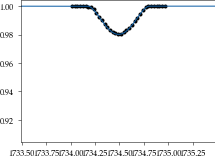

(1695.0199344699147, 1697.0199344699147)

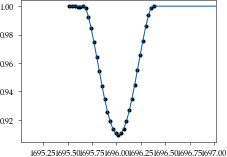

In [10]:
f_c, f_s = 6.19321053e-01, 1.69531989e-01

θ_initial = np.array([
    5.14192040e+01, # Period
    7.17949071e-02, # Rsum
    6.28722905e-01, # Rratio
    8.62150418e+01, # Incl
    6.91829286e-01, # Sbratio
    1.69601971e+03, # t0
    6.20730605e-01, # fc
    1.60481296e-01, # fs
    86, #sma
    -13.53, #gammava
    -13.53, #gammavb
    2.68060970e-01, # q11
    4.55712020e-01, # q12
    8.30538026e-01, # q21
    5.82431661e-02, # q22
    0., # mean
    27, #vsini
    0., #loglc
    0., #logrva
    0., #logrvb
])

θ_bounds = [
    (lit_period-1, lit_period+1), # Period
    (0.01, 0.1), #rsum
    (0.1, 0.9), #rratio
    (45, 90), #incl
    (0.01, 1.5), #sbratio
    (lit_t0-1, lit_t0+1), # T0
    (f_c - 0.1, f_c + 0.1), #fc
    (f_s - 0.1, f_s + 0.1), # fs
    (10, 150.), # sma
    (-20, -5), # gammava
    (-20, -5), # gammavb
    (0., 1.),
    (0., 1.),
    (0., 1.),
    (0., 1.),
    (-0.1, 0.1), #mean
    (26, 28), #vsini
    (-10, 10), #loglc
    (-10, 10), #logrv
    (-10, 10), #logrvb
]

plt.plot(time[::20], flux[::20], '.k')
plt.plot(time, lc_model(θ_initial, time))
plt.xlim(lit_t1-1, lit_t1+1)
plt.show()

plt.plot(time[::20], flux[::20], '.k')
plt.plot(time, lc_model(θ_initial, time))
plt.xlim(lit_t0-1, lit_t0+1)

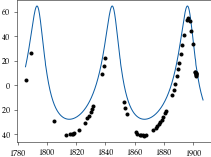

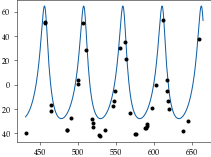

In [11]:
test_time = np.linspace(rv_song[:,0][0], rv_song[:,0][-1]+5, 1000)
plt.plot(test_time, rv_model(θ_initial, test_time))
plt.plot(rv_song[:,0], rv_song[:,1], '.k')
plt.show()

test_time = np.linspace(rv_bischoff[:,0][0], rv_bischoff[:,0][-1]+5, 1000)
plt.plot(test_time, rv_model(θ_initial, test_time))
plt.plot(rv_bischoff[:,0], rv_bischoff[:,1], '.k')

In [12]:
nll(θ_initial, time[::20], flux[::20], flux_err[::20],
      rv_song, rv_bischoff)

302.70158608288614

In [10]:
# from scipy.optimize import differential_evolution, minimize

# soln = differential_evolution(nll, θ_bounds, args=(time[::20], flux[::20], flux_err[::20],
#       rv_song, rv_bischoff), workers=-1)

In [11]:
# soln

In [12]:
# pp = ['period', 'rsum', 'rratio', 'incl', 'sbratio', 't0', 'f_c', 'f_s', 'sma', 'gammav', 'q11', 'q12', 'q21', 'q22', 'loglc', 'mean']

In [13]:
θ_initial = np.array([ 5.14221870e+01,  6.96559105e-02,  4.15510254e-01,  8.64884638e+01,
        9.70322133e-01,  1.69601907e+03,  6.06249065e-01,  2.40106807e-01,
        8.60222114e+01, -1.15555486e+01,  3.17392634e-01,  1.44387715e-01,
        9.53385140e-01,  4.61662394e-01,  -8.00335711e+00,
       -1.39018357e-04, ])

θ_initial = np.array([ 5.14221870e+01,  6.96559105e-02,  4.15510254e-01,  8.64884638e+01,
        9.70322133e-01,  1.69601907e+03,  6.06249065e-01,  2.40106807e-01,
        8.60222114e+01, -1.15555486e+01,  -1.34739536e+01,  3.17392634e-01,  1.44387715e-01,
        9.53385140e-01,  4.61662394e-01, -1.39018357e-04,
        2.62404499e+01, -8.00335711e+00, -4.72366970e+00, -4.23543830e+00])


 #   period, rsum, rratio, incl, sbratio, t0, f_c, f_s, sma, gammava, gammavb, q11, q12, q21, q22, mean, vsini, loglc, logrv_a, logrv_b = θ


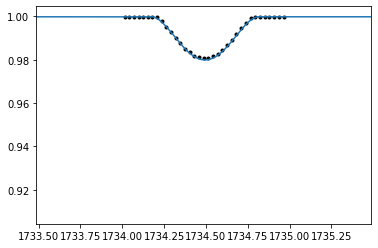

(1695.0199344699147, 1697.0199344699147)

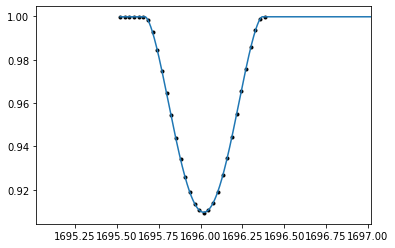

In [14]:
plt.plot(time[::20], flux[::20], '.k')
plt.plot(time, lc_model(θ_initial, time))
plt.xlim(lit_t1-1, lit_t1+1)
plt.show()

plt.plot(time[::20], flux[::20], '.k')
plt.plot(time, lc_model(θ_initial, time))
plt.xlim(lit_t0-1, lit_t0+1)

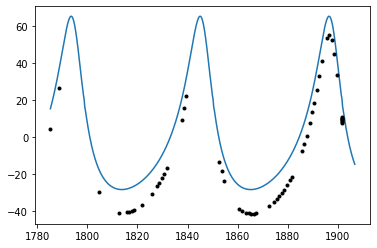

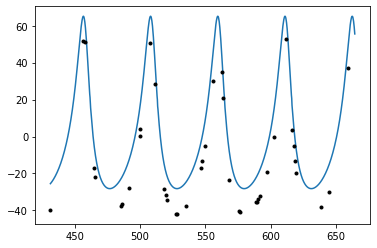

In [15]:
test_time = np.linspace(rv_song[:,0][0], rv_song[:,0][-1]+5, 1000)
plt.plot(test_time, rv_model(θ_initial, test_time))
plt.plot(rv_song[:,0], rv_song[:,1], '.k')
plt.show()

test_time = np.linspace(rv_bischoff[:,0][0], rv_bischoff[:,0][-1]+5, 1000)
plt.plot(test_time, rv_model(θ_initial, test_time))
plt.plot(rv_bischoff[:,0], rv_bischoff[:,1], '.k')

In [13]:
import emcee

pos = θ_initial + 1e-4 * np.random.randn(100, len(θ_initial))
nwalkers, ndim = pos.shape

filename = "chains/ellc_with_vsini_both_RV.h5"
backend = emcee.backends.HDFBackend(filename)

# Below is fow sampling .. !
# backend.reset(nwalkers, ndim)

# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(time, flux, flux_err, x_song, y_song, y_song_err))
# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(time[::20], flux[::20],flux_err[::20], rv_song, rv_bischoff), backend=backend)

# sampler.run_mcmc(pos, 15000, progress=True);

In [14]:
import corner
flat_samples = backend.get_chain(discard=10000, 
#                                  thin=1÷5, 
                                 flat=True)

In [41]:
import matplotlib

matplotlib.rcParams.update({'font.size': 6,
                           'xtick.labelsize' : 6.,
'ytick.labelsize' : 6.,
'axes.labelsize' : 6.})

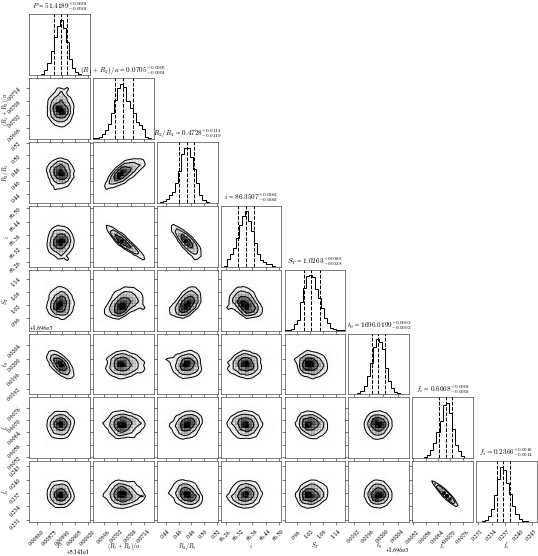

In [48]:
pp = [
     '$P$', '$(R_1 + R_2) / a$', '$R_2 / R_1$', '$i$', '$S_T$', '$t_0$', '$f_c$', '$f_s$', '$a_1$', 'gammava', 
    'gammavb', 'q11', 'q12', 'q21', 'q22', 'mean', 'vsini', 'loglc', 'logrv_a', 'logrv_b'

]

fig = plt.figure(figsize=[7.64, 7.64])
corner.corner(
    flat_samples[:,:8], labels=pp, fig=fig, rasterized=True,
    show_titles=True, smooth=0.5, quantiles=[0.16, 0.5, 0.84], fill_contours=False, plot_datapoints=False,title_fmt='.4f',# truths=[m_true, b_true, np.log(f_true)]
);
plt.savefig('chains/corner.pdf', dpi=300)

# Parameters

In [94]:
labels = [
     'period', 'rsum', 'rratio', 'incl', 'sbratio', 't0', 'f_c', 'f_s', 'sma', 'gammava', 
    'gammavb', 'q11', 'q12', 'q21', 'q22', 'mean', 'vsini', 'loglc', 'logrv_a', 'logrv_b'

]

In [111]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    print(txt)


\mathrm{period} = 51.4_{-0.0}^{+0.0}
\mathrm{rsum} = 0.1_{-0.0}^{+0.0}
\mathrm{rratio} = 0.5_{-0.0}^{+0.0}
\mathrm{incl} = 86.4_{-0.0}^{+0.0}
\mathrm{sbratio} = 1.0_{-0.0}^{+0.0}
\mathrm{t0} = 1696.0_{-0.0}^{+0.0}
\mathrm{f_c} = 0.6_{-0.0}^{+0.0}
\mathrm{f_s} = 0.2_{-0.0}^{+0.0}
\mathrm{sma} = 89.1_{-0.1}^{+0.1}
\mathrm{gammava} = -11.7_{-0.0}^{+0.0}
\mathrm{gammavb} = -13.5_{-0.1}^{+0.1}
\mathrm{q11} = 0.2_{-0.1}^{+0.1}
\mathrm{q12} = 0.5_{-0.3}^{+0.3}
\mathrm{q21} = 0.2_{-0.1}^{+0.2}
\mathrm{q22} = 0.5_{-0.3}^{+0.3}
\mathrm{mean} = -0.0_{-0.0}^{+0.0}
\mathrm{vsini} = 27.6_{-0.6}^{+0.3}
\mathrm{loglc} = -8.0_{-0.1}^{+0.1}
\mathrm{logrv_a} = -5.0_{-0.2}^{+0.2}
\mathrm{logrv_b} = -4.9_{-3.4}^{+0.8}


# Derived quantities

In [126]:
import astropy.units as u
import astropy.constants as c

In [141]:
rsum = flat_samples[:,1]
rratio = flat_samples[:,2]

r1, r2 = rsum/(1.+rratio), rsum*rratio/(1.+rratio)
e, w = flat_samples[:,6]**2 + flat_samples[:,7]**2, np.arctan(flat_samples[:,7] / flat_samples[:,6])#6,7
K = (2 * np.pi / (flat_samples[:,0] * u.day).to(u.s)) * ((flat_samples[:,8]*u.R_sun).to(u.km) * np.sin(np.radians(flat_samples[:,3]))) / np.sqrt(1 - 0.4**2) /2
mf = ((flat_samples[:,0] * u.day).to(u.s) * ((K).to(u.m/u.s))**3 * (1 - (0.4122996619833249)**2)**(3/2) / (2 * np.pi * c.G)).to(u.Msun).value
K = K.value

for p in [r1, r2, e, w, mf, K]:
    mcmc = np.percentile(p, [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.2f}_{{-{1:.2f}}}^{{+{2:.2f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], 'b')
    print(txt)


\mathrm{b} = 0.05_{-0.00}^{+0.00}
\mathrm{b} = 0.02_{-0.00}^{+0.00}
\mathrm{b} = 0.42_{-0.00}^{+0.00}
\mathrm{b} = 0.37_{-0.00}^{+0.00}
\mathrm{b} = 0.44_{-0.00}^{+0.00}
\mathrm{b} = 47.74_{-0.06}^{+0.06}


# LC and RV plots

In [50]:
o_time, o_flux, o_flux_err = np.loadtxt('data/photometry/tess_corrected.txt', usecols=(0,1,2)).T

median_model = lc_model(np.median(flat_samples, axis=0), o_time)
per = np.median(flat_samples, axis=0)[0]
t0 = np.median(flat_samples, axis=0)[5]

In [51]:
overleaf_path = '/Users/daniel/Dropbox (Sydney Uni)/Apps/Overleaf/adra/figs/'

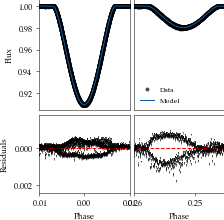

In [186]:
phase = t0 % per / per
fold = (((o_time - phase * per) / per) % 1)
fold[fold > 0.5] -= 1
sort = np.argsort(fold)

fig, axes = plt.subplots(2,2, figsize=[10/3, 3.560113295832983], gridspec_kw={'height_ratios': [1, 0.7]})
axes = axes.flatten()

ax = axes[0]
ax.plot(fold[sort], o_flux[sort], '.k', alpha=0.6, rasterized=True)
ax.plot(fold[sort], median_model[sort], c='C0', lw=1)
ax.set(xlim=[-0.01, 0.01], xticks=[], ylabel='Flux')

ax = axes[2]
ax.errorbar(fold[sort], o_flux[sort] - median_model[sort], yerr=o_flux_err, fmt=',k', alpha=0.6, rasterized=True)
ax.set_xlim(-0.01, 0.01)
ax.axhline(0., c='red', linestyle='dashed')
ax.set(ylabel='Residuals', xlabel='Phase')

ax = axes[1]
ax.plot(fold[sort], o_flux[sort], '.k', alpha=0.6, rasterized=True, label='Data')
ax.plot(fold[sort], median_model[sort], c='C0', lw=1, label='Model')
ax.set(xlim=[-0.26, -0.245], yticks=[], xticks=[])
ax.legend(fontsize=7)

ax = axes[3]
ax.errorbar(fold[sort], o_flux[sort] - median_model[sort], yerr=o_flux_err, fmt=',k', alpha=0.6, rasterized=True)
ax.axhline(0., c='red', linestyle='dashed')
ax.set(xlim=[-0.26, -0.245], yticks=[], xlabel='Phase')

plt.subplots_adjust(hspace=0.05, wspace=0.05)

plt.savefig('plots/' + 'lc_fit.pdf', dpi=300)

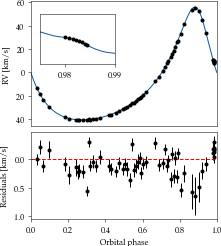

In [187]:
# fig, axes = plt.subplots(2, 1, figsize=[10/3, 2.], gridspec_kw={'height_ratios': [1, 0.7]})
fig, axes = plt.subplots(2, 1, figsize=[10/3, 4], gridspec_kw={'height_ratios': [1, 0.7]})

porb = np.median(flat_samples[:,0])

ax = axes[0]
synth_x = np.linspace(rv_song[:,0][0], rv_song[:,0][-1], 1000)
fold = synth_x % porb / porb
sort = np.argsort(fold)
synth_model = rv_model(np.median(flat_samples, axis=0), synth_x) + np.median(flat_samples[:,9])

ax.errorbar(rv_song[:,0] % porb / porb, rv_song[:,1], yerr=rv_song[:,2],fmt='.k')
ax.plot(fold[sort], synth_model[sort])
ax.set_xticks([])
ax.set_ylabel('RV [km/s]')
ax.set_xlim(0, 1)

ax2 = ax.inset_axes([0.05, 0.5, 0.4, 0.4])
ax2.plot(fold[sort], synth_model[sort])
ax2.errorbar(rv_song[:,0] % porb / porb, rv_song[:,1], yerr=rv_song[:,2],fmt='.k')
ax2.set_xlim(0.975, 0.99)
ax2.set_ylim(0, 20)
ax2.set_yticks([])

ax = axes[1]
fold = rv_song[:,0] % porb / porb
sort = np.argsort(fold)
ax.errorbar(fold[sort], (rv_song[:,1] -  (rv_model(np.median(flat_samples, axis=0), rv_song[:,0]) + np.median(flat_samples[:,9])))[sort], 
            fmt='.k',
           yerr=rv_song[:,2])
ax.axhline(0., c='red', linestyle='dashed')
ax.set_xlabel('Orbital phase')
ax.set_ylabel('Residuals [km/s]')
ax.set_xlim(0, 1)
plt.subplots_adjust(hspace=0.05)

plt.savefig('plots/' + 'rv_fit.pdf', dpi=300)